<a href="https://colab.research.google.com/github/Orri050/Lokaverkefni/blob/main/Lokaverkefni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forritið

## Grunnur

In [121]:
pip install yfinance

In [122]:
pip install plotly

In [123]:
import tensorflow as tf
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Val á hlutabréfi

In [ ]:
choice = input('Write a stock symbol:')
choice = choice.upper()

Write a stock symbol:AAPL


## Hlutabréf gögn

In [124]:
data = yf.download(tickers=choice, start="2019-03-04", end="2022-04-30", interval='1d')
#data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)

[*********************100%***********************]  1 of 1 completed


In [128]:
data_Open=data[['Open']] #this returns a DataFrame, you don't need loc
data_dates=data.index.to_frame().reset_index(drop=True)
data_dates=data_dates.apply(pd.to_datetime)

### yf.ticker 

In [126]:
yf.pdr_override()
stock = yf.Ticker(choice)

In [127]:
stockh = stock.history(period='max',start="2019-03-04",end="2022-04-30", interval='1d')
#stockh = stock.history(period='max', interval='1d')
stockh

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-04,42.767356,43.268811,42.348665,42.806305,109744800,0.0,0.0
2019-03-05,42.828210,42.842815,42.487413,42.728405,78949600,0.0,0.0
2019-03-06,42.519060,42.718670,42.341361,42.482548,83241600,0.0,0.0
2019-03-07,42.324313,42.463067,41.873979,41.990822,99185600,0.0,0.0
2019-03-08,41.460160,42.129578,41.260549,42.090630,95997600,0.0,0.0
...,...,...,...,...,...,...,...
2022-04-08,171.779999,171.779999,169.199997,170.089996,76515900,0.0,0.0
2022-04-11,168.710007,169.029999,165.500000,165.750000,72246700,0.0,0.0
2022-04-12,168.020004,169.869995,166.639999,167.660004,79265200,0.0,0.0


In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
stockh.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06',
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14'],
              dtype='datetime64[ns]', name='Date', length=788, freq=None)

In [ ]:
stockh_Open=stockh[['Open']] #this returns a DataFrame, you don't need loc
stockh_dates=stockh.index.to_frame().reset_index(drop=True)
stockh_dates=stockh_dates.apply(pd.to_datetime)

In [ ]:
jon=stock.dividends
divi_dates=jon.index.to_frame().reset_index(drop=True)
divi_dates=divi_dates.apply(pd.to_datetime)
print(divi_dates)

         Date
0  2019-05-10
1  2019-08-09
2  2019-11-07
3  2020-02-07
4  2020-05-08
5  2020-08-07
6  2020-11-06
7  2021-02-05
8  2021-05-07
9  2021-08-06
10 2021-11-05
11 2022-02-04


## Open close

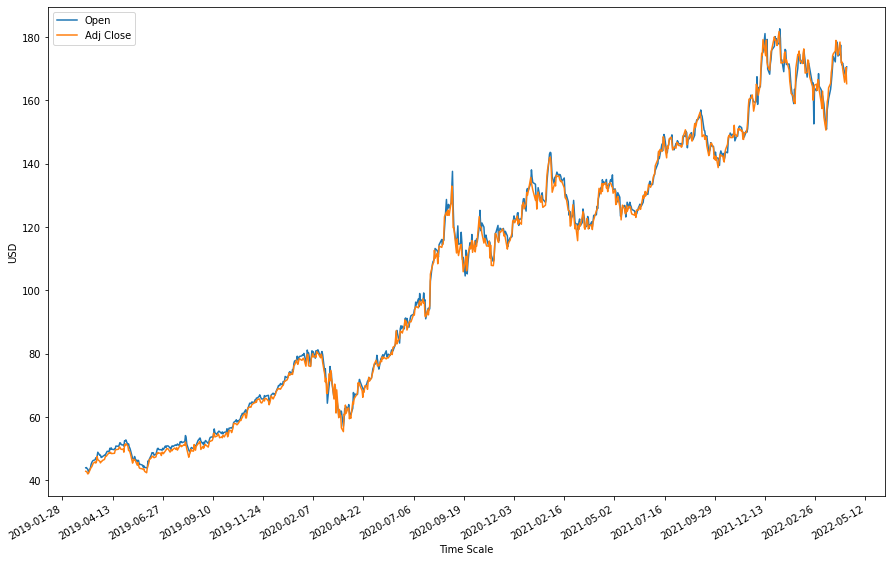

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['Open'], label='Open')
plt.plot(x_dates, data['Adj Close'], label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## High low

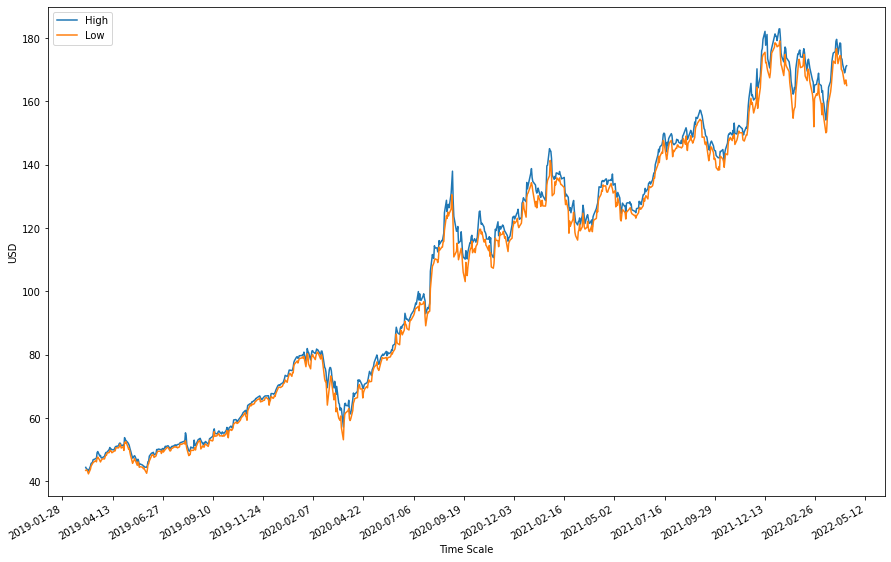

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['High'], label='High')
plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Fyrsta spá

### Gagnaundirbúningur

In [ ]:
target_y = data['Adj Close']
X_feat= data.iloc[:,0:5]
h_feat=data.iloc[:,4]

In [130]:
h_feat

Date
2019-03-04     42.806301
2019-03-05     42.728413
2019-03-06     42.482544
2019-03-07     41.990822
2019-03-08     42.090633
                 ...    
2022-04-08    170.089996
2022-04-11    165.750000
2022-04-12    167.660004
2022-04-13    170.399994
2022-04-14    165.289993
Name: Adj Close, Length: 788, dtype: float64

In [129]:
X_feat

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-03-04,43.922501,44.437500,43.492500,43.962502,42.806301
2019-03-05,43.985001,44.000000,43.634998,43.882500,42.728413
2019-03-06,43.667500,43.872501,43.485001,43.630001,42.482544
2019-03-07,43.467499,43.610001,43.005001,43.125000,41.990822
2019-03-08,42.580002,43.267502,42.375000,43.227501,42.090633
...,...,...,...,...,...
2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996
2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000
2022-04-12,168.020004,169.869995,166.639999,167.660004,167.660004


In [131]:
h_ft=np.array(h_feat)
h_ft=h_ft.reshape(-1,1)

In [132]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)


In [133]:
h_ft=sc.fit_transform(h_ft)

In [134]:
def lstm_split(data, n_steps):
  X, y=[], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i+n_steps,:-1])
    y.append(data[i+n_steps-1,-1])

  return np.array(X), np.array(y)


In [186]:
X1, y1= lstm_split(X_ft.values, n_steps=1)

train_split=0.8
split_idx= int(np.ceil(len(X1)*train_split))
date_index=X_ft.index

Xtr, Xtst= X1[:split_idx], X1[split_idx:]
ytr, ytst= y1[:split_idx], y1[split_idx:]
Xtrd, Xtstd= date_index[:split_idx], date_index[split_idx:]

print(X1.shape, Xtr.shape, Xtst.shape, ytst.shape)

(788, 1, 4) (631, 1, 4) (157, 1, 4) (157,)


In [136]:
model = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr.shape[1],Xtr.shape[2]), activation="relu",return_sequences=True),
    keras.layers.Dense(1)])
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 32)             4736      
                                                                 
 dense_4 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(Xtr,ytr,epochs=100,batch_size=4,verbose=2,shuffle=False)

In [138]:
ypr=model.predict(Xtst)
ypr=ypr.reshape(-1)

### Lærdómskúrva

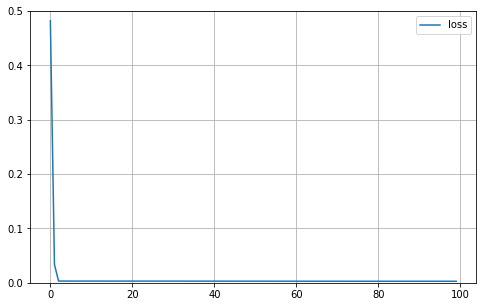

In [139]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.5)
plt.show()

### Samanburður á raunverulegu close og mati LSTM

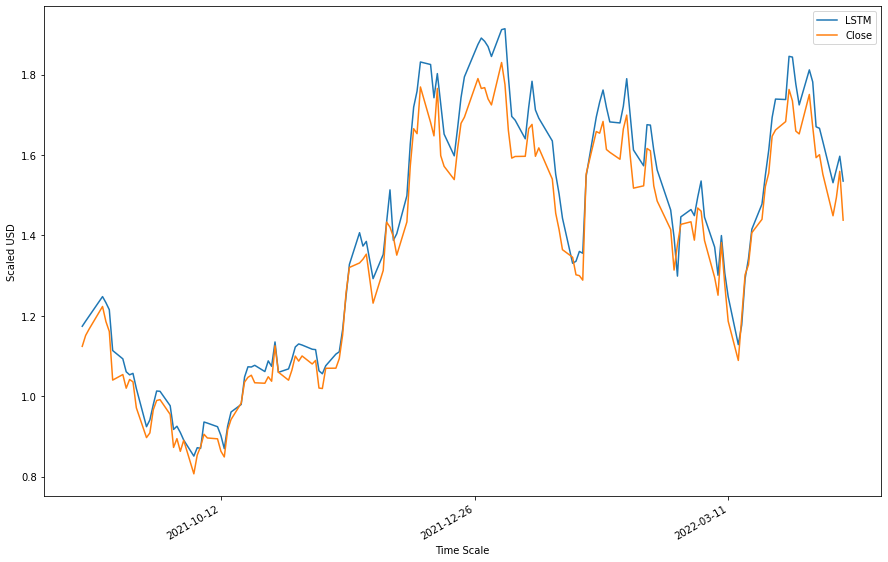

In [140]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr)
x_dates=data_dates[k:]
#h=stockh['Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr, label='LSTM')
plt.plot(x_dates, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [141]:
rmse=mean_squared_error(ytst,ypr,squared=False)
mape=mean_absolute_percentage_error(ytst,ypr)
print("RSME:",rmse)
print("MAPE:",mape)

RSME: 0.06365322053819326
MAPE: 0.03822011792301501


## Önnur *spá*

### Þjálfun

In [181]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr.shape[1],Xtr.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model2.compile(loss="mean_squared_error", optimizer="adam")
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 10, 50)            11000     
                                                                 
 lstm_36 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_37 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1=model2.fit(Xtr,ytr,epochs=100,batch_size=4,verbose=2,shuffle=False)

In [ ]:
ypr2=model2.predict(Xtst)
ypr2=ypr2.reshape(-1)

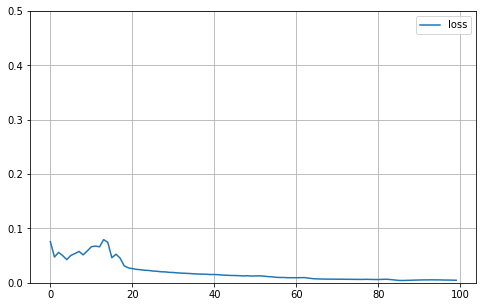

In [184]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.5)
plt.show()

### Samanburður á raunverulegu og LSTM

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr)
x_dates=data_dates[k:]
#h=data['Adj Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr2, label='LSTM')
plt.plot(x_dates, h, label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [155]:
rmse2=mean_squared_error(ytst,ypr2,squared=False)
mape2=mean_absolute_percentage_error(ytst,ypr2)
print("RSME:",rmse2)
print("MAPE:",mape2)

RSME: 0.07173561867796138
MAPE: 0.035378703544480666


## Þriðja spá

### Þjálfun

In [196]:
n_steps=10
X1, y1= lstm_split(X_ft.values, n_steps=n_steps)

train_split=0.8
split_idx= int(np.ceil(len(X1)*train_split))
date_index=X_ft.index

Xtr, Xtst= X1[:split_idx], X1[split_idx:]
ytr, ytst= y1[:split_idx], y1[split_idx:]
Xtrd, Xtstd= date_index[:split_idx], date_index[split_idx:-n_steps+1]

print(X1.shape, Xtr.shape, Xtst.shape,Xtstd.shape, ytst.shape)

(779, 10, 4) (624, 10, 4) (155, 10, 4) (155,) (155,)


In [190]:
#model = Sequential()
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.1))
#model.add(LSTM(50))
#model.add(Dropout(0.1))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
#model3 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr.shape[1],Xtr.shape[2]), activation="relu",return_sequences=True),
    #keras.layers.LSTM(50,activation="relu"),
    #keras.layers.Dense(1)])
#model3.compile(loss="mean_squared_error", optimizer="adam")
#model3.summary()

In [191]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)])
model3.compile(loss="mean_squared_error", optimizer="adam")

In [192]:
history = model3.fit(Xtr, ytr, epochs=100, batch_size=50, validation_data=(Xtst, ytst), verbose=1, shuffle=False)

Epoch 1/100
13/13 [==============================] - 5s 96ms/step - loss: 0.4191 - val_loss: 0.4573
Epoch 2/100
13/13 [==============================] - 0s 21ms/step - loss: 0.1156 - val_loss: 0.2604
Epoch 3/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0413 - val_loss: 0.0694
Epoch 4/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0326 - val_loss: 0.0564
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0205 - val_loss: 0.1438
Epoch 6/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0186 - val_loss: 0.1139
Epoch 7/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0179 - val_loss: 0.0894
Epoch 8/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0162 - val_loss: 0.0899
Epoch 9/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0148 - val_loss: 0.0867
Epoch 10/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0141 - val_loss: 0.0885

In [193]:
ypr3=model3.predict(Xtst)
ypr3=ypr3.reshape(-1)

### Samanburður

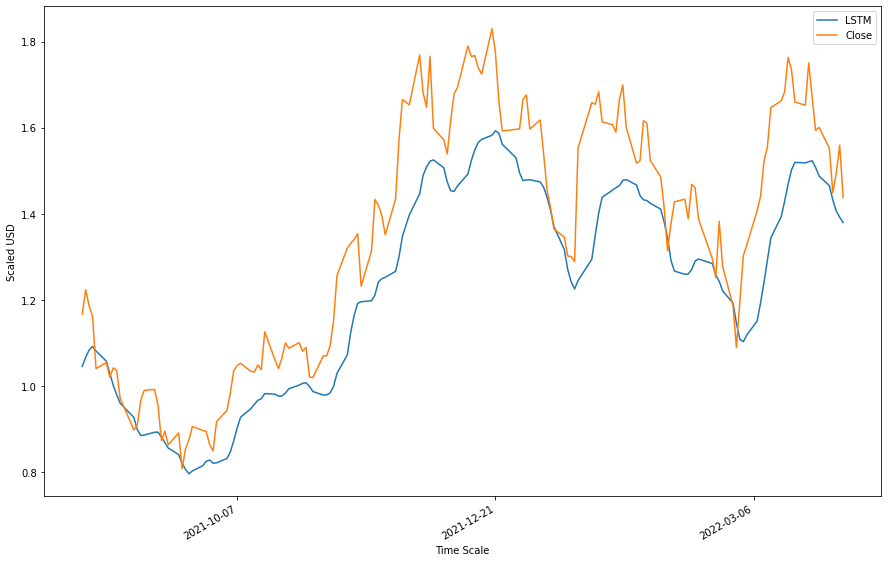

In [194]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr)
thri=len(X1)-len(Xtstd)
x_dates=data_dates[k:]
#h=stockh['Close']
n=n_steps-1
h=h_ft[thri+n:]
#h=h[k:]
plt.plot(Xtstd, ypr3, label='LSTM')
plt.plot(Xtstd, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE

In [195]:
rmse3=mean_squared_error(ytst,ypr3,squared=False)
mape3=mean_absolute_percentage_error(ytst,ypr3)
print("RSME:",rmse3)
print("MAPE:",mape3)

RSME: 0.15293770877531868
MAPE: 0.09004816422431881


## MAPE

Test RMSE: 17.327
Test MAPE: 0.083


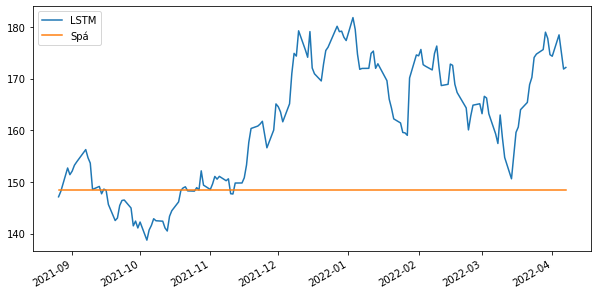

In [ ]:
train_split=0.8
split_idx2= int(np.ceil(len(stockh)*train_split))
tr=stockh[['Close']].iloc[:split_idx2]
tst=stockh[['Close']].iloc[split_idx2:]

tstpr=np.array([tr.rolling(10).mean().iloc[-1]]*len(tst)).reshape((-1,1))

print('Test RMSE: %.3f'%mean_squared_error(tst,tstpr,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst,tstpr))
f=len(tst)-len(h)
z=n-f
x_dates=stockh_dates[k+z:]


plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst, label='LSTM')
plt.plot(x_dates, tstpr, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test RMSE: 17.594
Test MAPE: 0.085


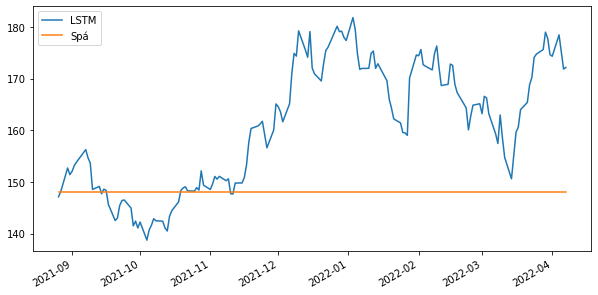

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

J=stockh[['Close']].values
train_split=0.8
split_idx3= int(np.ceil(len(J)*train_split))
tr2=J[:split_idx3]
tst2=J[split_idx3:]
tst_concat=np.array([]).reshape((0,1))

for i in range(len(tst2)):
  tr_fit=np.concatenate((tr2,np.asarray(tst_concat)))
  fit=SimpleExpSmoothing(np.asarray(tr_fit)).fit(smoothing_level=0.2)
  tst_pr=fit.forecast(1)
  tst_concat=np.concatenate((np.asarray(tst_concat),tst_pr.reshape((-1,1))))

print('Test RMSE: %.3f'%mean_squared_error(tst2,tst_concat,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst2,tst_concat))
f=len(tst2)-len(h)
z=n-f
x_dates=stockh_dates[k+z:]

plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst2, label='LSTM')
plt.plot(x_dates, tst_concat, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


## Nett innsláttargrafdót upp á lookið

In [ ]:
choice = input('Write a stock symbol:')
choice = choice.upper()
data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.index,open = data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name = 'market data'))
fig.add_trace(go.Scatter(x=data.index,y=data['MA5'],opacity=0.7,line=dict(color='blue', width=2),name='MA 5'))

fig.add_trace(go.Scatter(x=data.index,y=data['MA20'],opacity=0.7,line=dict(color='orange', width=2),name='MA 20'))
fig.update_layout(title = choice + ' share price', yaxis_title = 'Stock Price (USD)')
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
#dict(count=15, label='15m', step='minute', stepmode='backward'),
#dict(count=45, label='45m', step='minute', stepmode='backward'),
#dict(count=1, label='1h', step='hour', stepmode='backward'),
#dict(count=6, label='6h', step='hour', stepmode='backward'),
dict(count=30, label='30d', step='day', stepmode='backward'),
dict(count=3, label='3m', step='month', stepmode='backward'),
dict(count=6, label='6m', step='month', stepmode='backward'),
dict(count=1, label='YTD', step='year', stepmode='todate'),
dict(count=1, label='1y', step='year', stepmode='backward'),
dict(count=3, label='3y', step='year', stepmode='backward'),
dict(step='all')
])
)
)
fig.show()

Write a stock symbol:EIM.IC
[*********************100%***********************]  1 of 1 completed


## fram í tímann

### val á gögnum

In [ ]:
df1=data.reset_index()['Adj Close']
df1

0       38.277523
1       34.464802
2       35.936085
3       35.856087
4       36.539619
          ...    
824    170.089996
825    165.750000
826    167.660004
827    170.399994
828    165.289993
Name: Adj Close, Length: 829, dtype: float64

### Mynd af gögnum sem voru valin

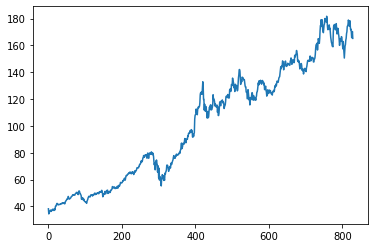

In [ ]:
plt.plot(df1)

### Gagnavinnsla

In [197]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [198]:
#print(df1)

In [199]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [200]:
training_size,test_size

(538, 291)

In [201]:
#train_data

In [202]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [203]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [204]:
print(X_train.shape), print(y_train.shape)

(437, 100)
(437,)


(None, None)

In [205]:
print(X_test.shape), print(ytest.shape)

(190, 100)
(190,)


(None, None)

In [206]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Modelið

In [ ]:
model6 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model6.compile(loss="mean_squared_error", optimizer="adam")
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_6 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model6.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=2)

Epoch 1/100
7/7 - 8s - loss: 0.0579 - val_loss: 0.0136 - 8s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 0.0111 - val_loss: 0.0811 - 1s/epoch - 209ms/step
Epoch 3/100
7/7 - 1s - loss: 0.0072 - val_loss: 0.0086 - 1s/epoch - 204ms/step
Epoch 4/100
7/7 - 1s - loss: 0.0037 - val_loss: 0.0104 - 1s/epoch - 209ms/step
Epoch 5/100
7/7 - 1s - loss: 0.0022 - val_loss: 0.0089 - 1s/epoch - 201ms/step
Epoch 6/100
7/7 - 1s - loss: 0.0015 - val_loss: 0.0023 - 1s/epoch - 201ms/step
Epoch 7/100
7/7 - 1s - loss: 0.0014 - val_loss: 0.0041 - 1s/epoch - 195ms/step
Epoch 8/100
7/7 - 1s - loss: 0.0014 - val_loss: 0.0026 - 1s/epoch - 192ms/step
Epoch 9/100
7/7 - 1s - loss: 0.0013 - val_loss: 0.0038 - 1s/epoch - 196ms/step
Epoch 10/100
7/7 - 1s - loss: 0.0013 - val_loss: 0.0038 - 1s/epoch - 198ms/step
Epoch 11/100
7/7 - 1s - loss: 0.0013 - val_loss: 0.0043 - 1s/epoch - 204ms/step
Epoch 12/100
7/7 - 1s - loss: 0.0013 - val_loss: 0.0033 - 1s/epoch - 206ms/step
Epoch 13/100
7/7 - 1s - loss: 0.0012 - val_loss: 0.0

### Spágögn búin til

In [ ]:
train_predict=model6.predict(X_train)
test_predict=model6.predict(X_test)

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### RMSE 

In [ ]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

89.87639459064552

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

156.17615148289707

### Mynd af einhverju (skoða)

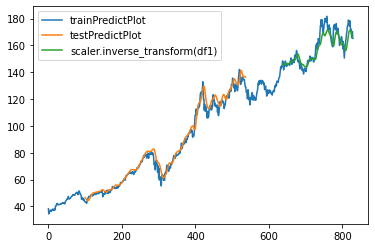

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['trainPredictPlot', 'testPredictPlot','scaler.inverse_transform(df1)'],loc='upper left')
plt.show()

### Framtíðargögn sett í fylki

In [ ]:
len(test_data)

291

In [ ]:
timi=len(test_data)-100


In [ ]:
x_input=test_data[timi:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
#temp_input

In [ ]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model6.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model6.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.87672967]
101
1 day input [0.86034027 0.86393348 0.8291541  0.85240809 0.88671296 0.88311976
 0.87627227 0.86325544 0.88684855 0.92657688 0.95301742 0.94949196
 0.98264429 0.95749198 0.94793276 0.98162734 0.93389887 0.92630581
 0.91688208 0.93884804 0.95681395 0.96115293 0.98861031 0.98155949
 0.98216968 0.97416976 0.96989863 1.         0.98433917 0.95193262
 0.93213625 0.93328879 0.93342437 0.95301742 0.95606817 0.93342437
 0.93939049 0.9172211  0.8930179  0.88135693 0.86711992 0.86176388
 0.8492895  0.84867931 0.84549297 0.9208143  0.95098351 0.94983098
 0.95816992 0.93823785 0.93626931 0.93131392 0.95283263 0.96267556
 0.93443646 0.91081341 0.91244262 0.93898456 0.93735545 0.91244262
 0.90171719 0.88148827 0.85263825 0.87076284 0.88508603 0.88691878
 0.87388537 0.89669386 0.89445373 0.87368173 0.84741128 0.83478515
 0.87218831 0.84211646 0.81638897 0.7884893  0.81883274 0.84937982
 0.8563717  0.87918019 0.88868379 0.91203535 0.921471   0.94767361
 0.95208592 0.9580596  0.98086809

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

829

In [ ]:
tim=len(df1)-100

Mynd af spá ósamsett

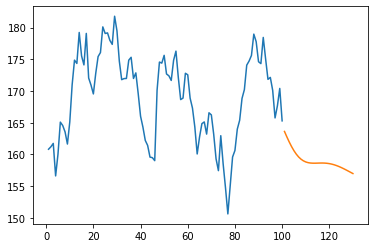

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[tim:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
timm=tim+30

### Mynd af spá samsett

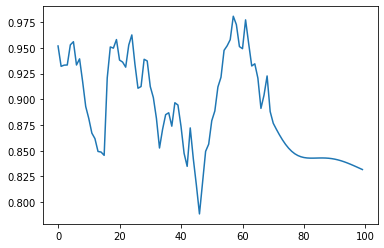

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[timm:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

### Mynd af heildargögnum með spá

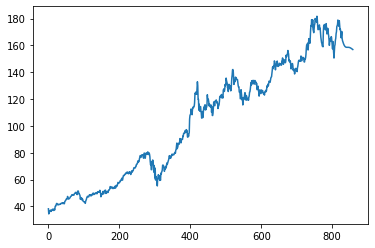

In [ ]:
plt.plot(df3)

## Fram í tímann (rusl)

In [ ]:
import math

In [ ]:
from numpy import newaxis

In [ ]:
import os
import json

In [ ]:
stockh_Close=stockh[['Close']]
stockh_Close

In [ ]:
target_y = stockh['Close']
X_feat= stockh.iloc[:,3:5]
h_feat=stockh.iloc[:,3]
X_feat

In [ ]:
#X_feat=np.array(X_feat)
#X_feat=X_feat.reshape(-1,1)

In [ ]:
X1, y1= lstm_split(X_feat.values, n_steps=1)

train_split=0.8
split_idx= int(np.ceil(len(X1)*train_split))
date_index=X_ft.index

Xtr, Xtst= X1[:split_idx], X1[split_idx:]
ytr, ytst= y1[:split_idx], y1[split_idx:]
Xtrd, Xtstd= date_index[:split_idx], date_index[split_idx:]

print(X1.shape, Xtr.shape, Xtst.shape, ytst.shape)

(783, 1, 1) (627, 1, 1) (156, 1, 1) (156,)


In [ ]:
model4 = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=(Xtr.shape[1],Xtr.shape[2]), activation="relu",return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(100,activation="relu", return_sequences=True),
    keras.layers.LSTM(100,activation="relu", return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)])
model4.compile(loss="mean_squared_error", optimizer="adam")
model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_26 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_42 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_43 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-t

In [ ]:
historyn=model4.fit(Xtr,ytr,epochs=2,batch_size=32,verbose=2,shuffle=False)

Epoch 1/2
20/20 - 0s - loss: 18896696461230080.0000 - 161ms/epoch - 8ms/step
Epoch 2/2
20/20 - 0s - loss: 18891553237893120.0000 - 142ms/epoch - 7ms/step


In [ ]:
sc= StandardScaler()

In [ ]:
#X_ft = sc.fit_transform(X_feat.values)
#X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)

In [ ]:
X_FUTURE = 100
predictions = np.array([])
last = Xtst[-1]
for i in range(X_FUTURE):
  curr_prediction = model4.predict(np.array([last]))
  print(curr_prediction)
  last = np.concatenate([last[1:], curr_prediction])
  predictions = np.concatenate([predictions, curr_prediction[0]])
  predictions = sc.fit_transform([predictions])[0]
  predictions = sc.inverse_transform([predictions])[0]
print(predictions)

NameError: ignored

In [ ]:
stockh.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05',
               '2022-04-06', '2022-04-07'],
              dtype='datetime64[ns]', name='Date', length=783, freq=None)

In [ ]:
import datetime
from datetime import timedelta
dicts = []
curr_date = stockh.index[-1]
for i in range(X_FUTURE):
  curr_date = curr_date + timedelta(days=1)
  dicts.append({'Predictions':predictions[i], "Date": curr_date})

new_data = pd.DataFrame(dicts).set_index("Date")

IndexError: ignored

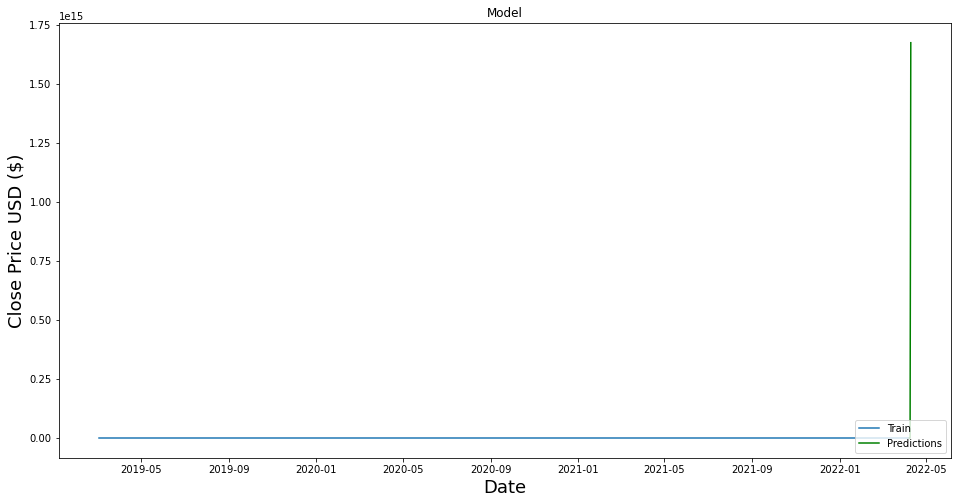

In [ ]:
#Plot the data
train = stockh
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(new_data['Predictions'],'g')
plt.legend(['Train', 'Predictions'], loc='lower right')
plt.show()